In [1]:
%matplotlib inline
%run ../../path_import.py
import numpy as np
import matplotlib.pyplot as plt
from plots import *
from utils import *
from training import *
from model_mu_reparam import *
import time
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [3]:
Data = torch.from_numpy(np.load('../rings_fixed_radius/obs.npy')).float()
## Data Parameters
N = 300
K = 3
D = 2
FIXED_RADIUS = 1.5
## Model Parameters
MCMC_SIZE = 10
SAMPLE_SIZE = 10
NUM_HIDDEN_GLOBAL = 8
NUM_HIDDEN_LOCAL = 64
STAT_SIZE = 8
NUM_LATENTS =  D
## Training Parameters
BATCH_SIZE = 20
NUM_EPOCHS = 1000
LEARNING_RATE =  1e-4
CUDA = torch.cuda.is_available()
PATH = 'ag-mcmc-resample-init-eta-%dsteps-%dsamples' % (MCMC_SIZE, SAMPLE_SIZE)
DEVICE = torch.device('cuda:1')

In [4]:
enc_mu = Enc_mu(K, D, num_hidden=NUM_HIDDEN_GLOBAL, num_stats=STAT_SIZE, CUDA=CUDA, device=DEVICE)
enc_z = Gibbs_z(K, CUDA, DEVICE)
obs_rad = torch.ones(1) * FIXED_RADIUS
noise_sigma = torch.ones(1) * 0.05
if CUDA:
    enc_mu.cuda().to(DEVICE)
    obs_rad = obs_rad.cuda().to(DEVICE)
    noise_sigma =noise_sigma.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(enc_mu.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [5]:
RESAMPLE=True
DETACH=True
train_mu(Eubo_cfz_init_z, enc_mu, enc_z, optimizer, Data, obs_rad, noise_sigma, K, NUM_EPOCHS, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE, PATH, CUDA, DEVICE, RESAMPLE=RESAMPLE, DETACH=DETACH)

epoch=0, SymKL=3609547.895, EUBO=-346076.990, ELBO=-4225767.530, ESS=1.002 (11s)
epoch=1, SymKL=3270634.425, EUBO=-328150.476, ELBO=-3836435.277, ESS=1.002 (11s)
epoch=2, SymKL=2965657.115, EUBO=-312438.634, ELBO=-3492196.103, ESS=1.001 (11s)
epoch=3, SymKL=2683077.130, EUBO=-297060.075, ELBO=-3169301.015, ESS=1.001 (11s)
epoch=4, SymKL=2430154.224, EUBO=-285880.063, ELBO=-2887753.013, ESS=1.002 (11s)
epoch=5, SymKL=2194931.087, EUBO=-272285.370, ELBO=-2620150.990, ESS=1.001 (11s)
epoch=6, SymKL=1975058.288, EUBO=-257422.492, ELBO=-2369581.864, ESS=1.001 (11s)
epoch=7, SymKL=1774125.536, EUBO=-240471.485, ELBO=-2139405.659, ESS=1.001 (11s)
epoch=8, SymKL=1593766.381, EUBO=-227305.856, ELBO=-1932764.369, ESS=1.001 (11s)
epoch=9, SymKL=1422204.945, EUBO=-212181.680, ELBO=-1734421.679, ESS=1.001 (11s)
epoch=10, SymKL=1267237.134, EUBO=-196509.831, ELBO=-1555596.311, ESS=1.001 (11s)
epoch=11, SymKL=1118550.999, EUBO=-183218.068, ELBO=-1384229.150, ESS=1.001 (11s)
epoch=12, SymKL=981722.603

KeyboardInterrupt: 

In [7]:
torch.save(enc_mu.state_dict(), "../weights/enc-mu-%s" % PATH)
# torch.save(enc_z.state_dict(), "../weights/enc-z-%s" % PATH)

CPU times: user 2.83 s, sys: 32 ms, total: 2.87 s
Wall time: 2.39 s


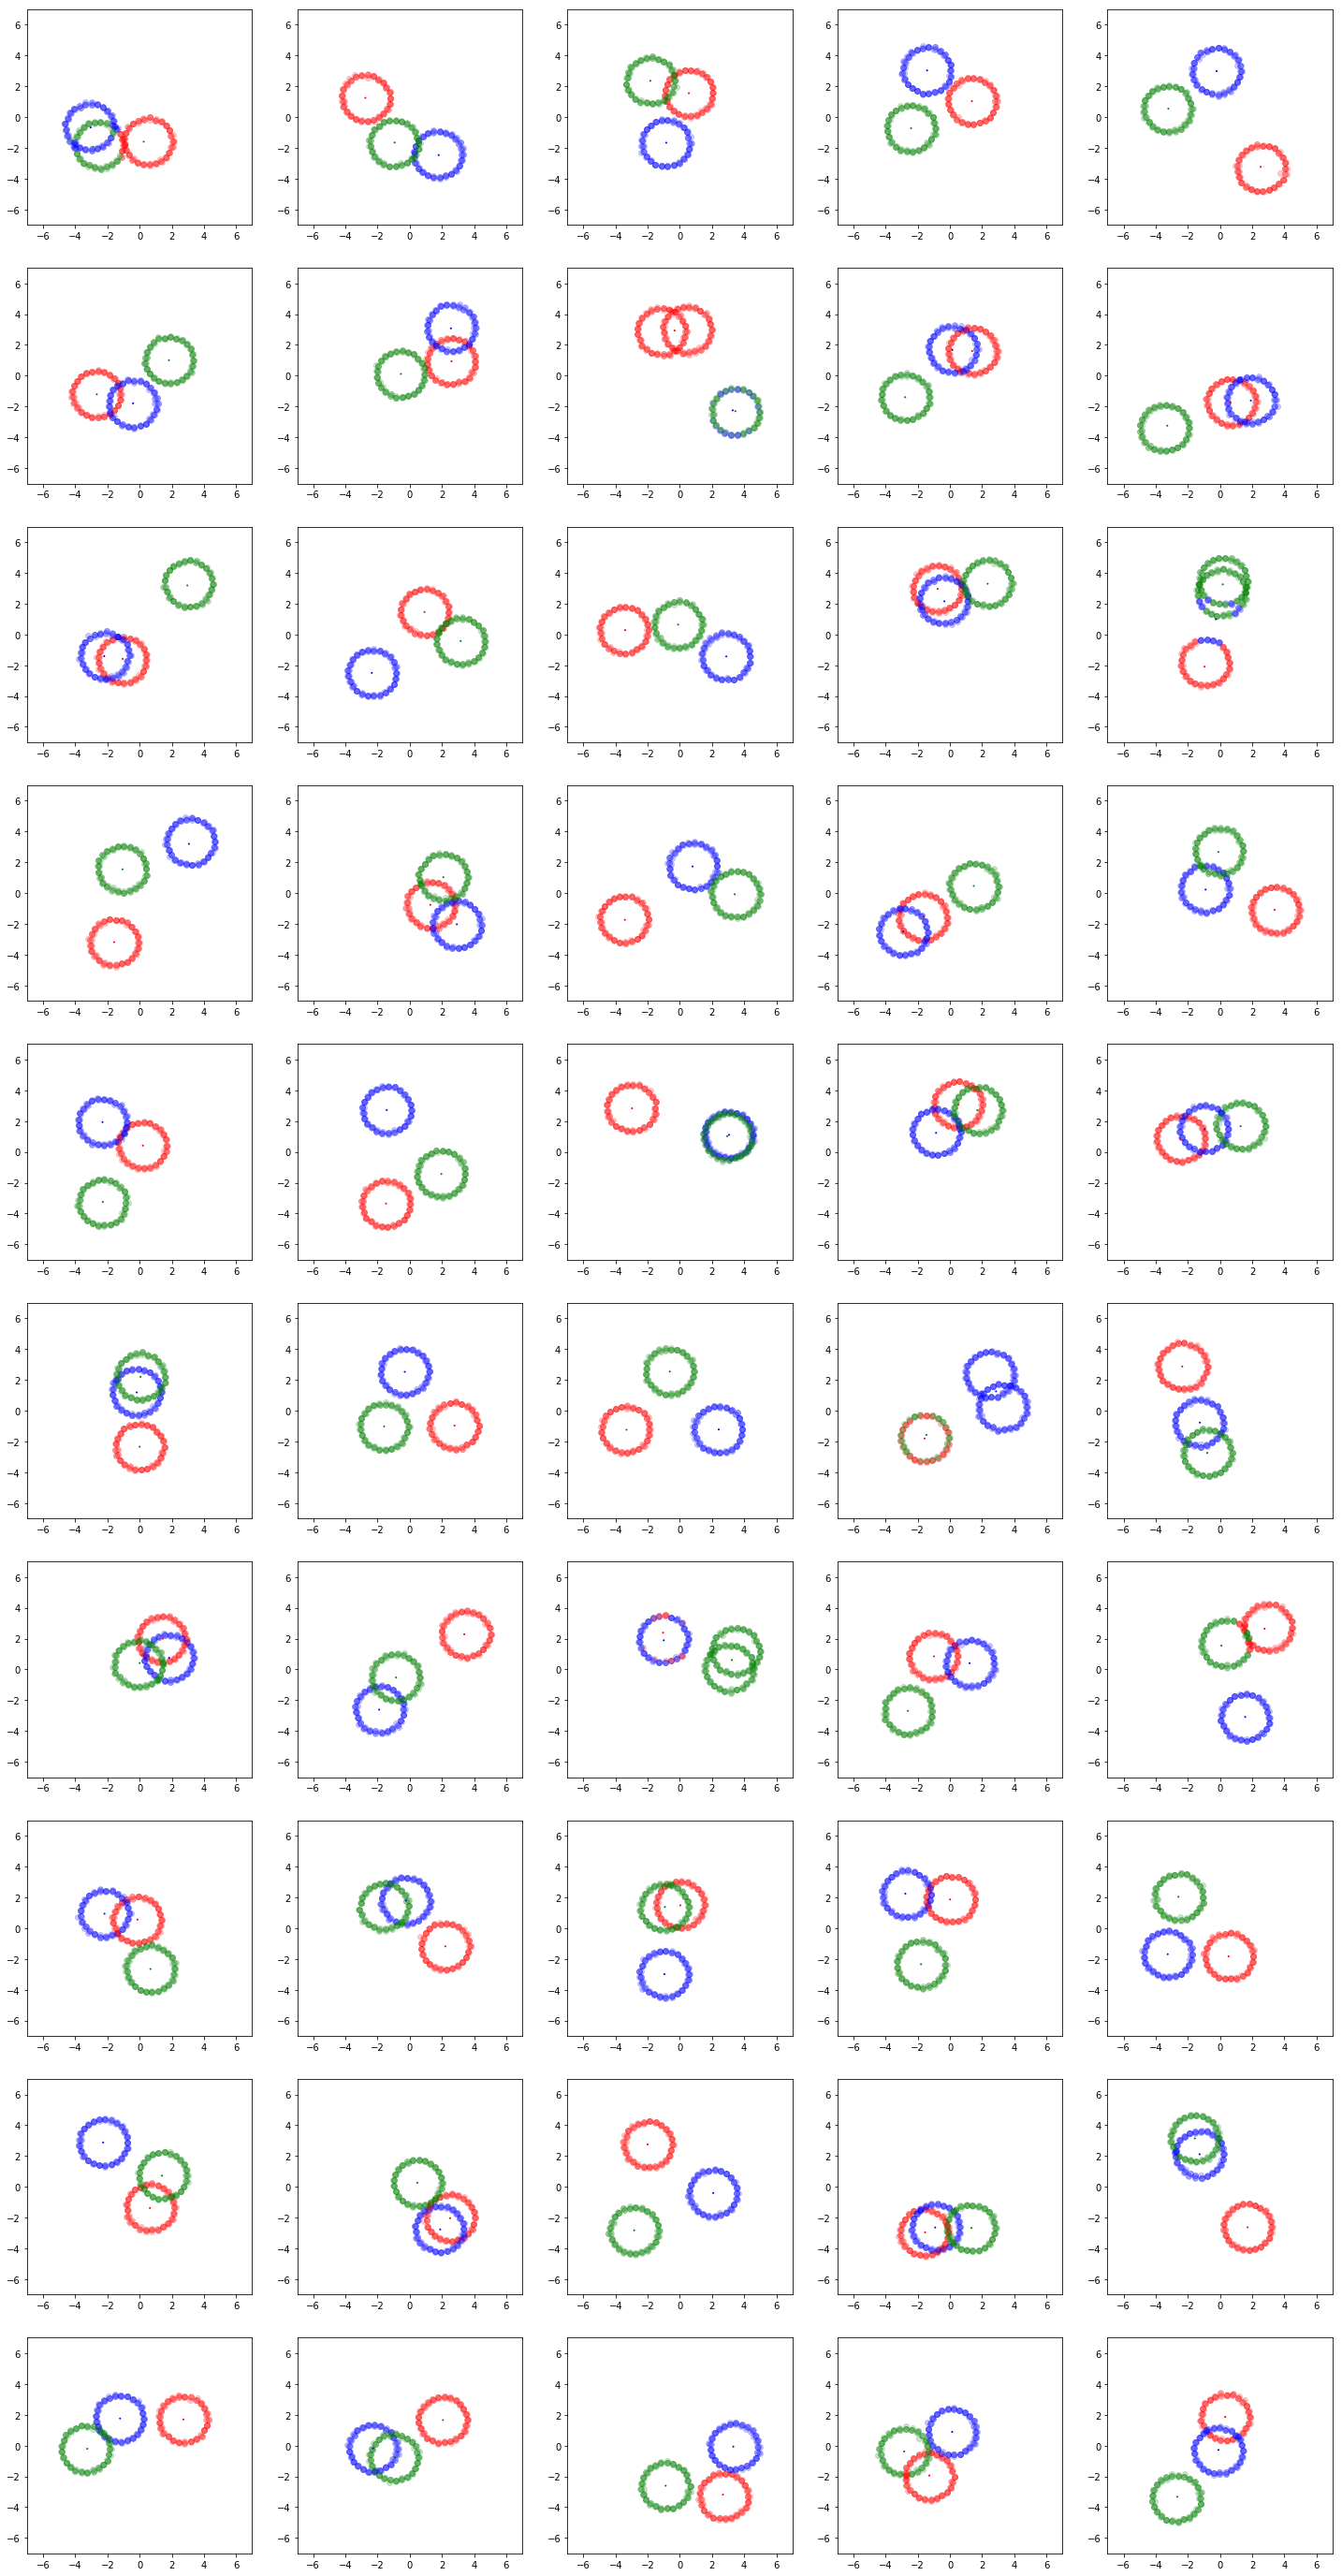

In [8]:
BATCH_SIZE_TEST = 50
obs, q_mu, q_z, symkls_test, eubos_test, elbos_test = test(Eubo_cfz_init_eta, enc_mu, enc_z, Data, obs_rad, noise_sigma, K, 10, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, RESAMPLE, DETACH=DETACH)
%time plot_samples(obs, q_mu, q_z, K, PATH)

In [10]:
incremental_gap = symkls_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

Text(0.5, 0, 'Steps')

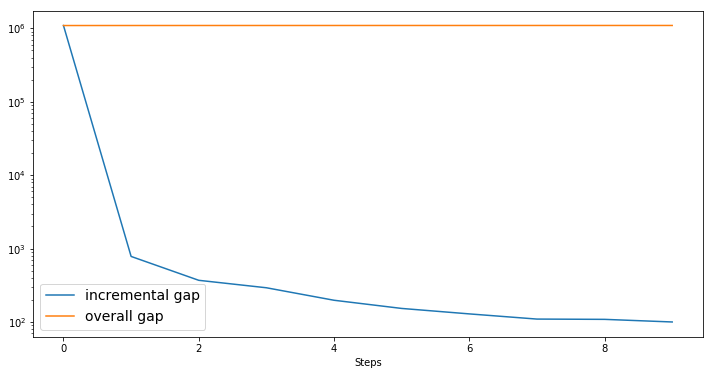

In [11]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')